In [ ]:
import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats
from tqdm.auto import tqdm

In [ ]:
df = pd.read_csv("7282_1_dedupe_cleaned.csv")
df = df[df["reviews.rating"].notna() & df["reviews.text"].notna()]

df_sampled = (
    df.groupby("name")
      .head(20)                     
      .reset_index(drop=True)
)

sent_df = df_sampled.copy()


In [ ]:
# Map ratings to binary sentiment and filter out 3-star reviews
df2 = sent_df.copy()
df2 = df2[['reviews.text', 'reviews.rating', 'province', 'city']].dropna()
df2['reviews.rating'] = pd.to_numeric(df2['reviews.rating'], errors='coerce')
df2 = df2.dropna(subset=['reviews.rating'])
df2 = df2[df2['reviews.rating'] != 3]
df2['sentiment'] = df2['reviews.rating'].apply(lambda r: 1 if r >= 4 else 0)
print('Total reviews after filtering (no 3-star):', len(df2))
print(df2['sentiment'].value_counts())

Total reviews after filtering (no 3-star): 8460
sentiment
1    6522
0    1938
Name: count, dtype: int64


In [ ]:
# Balance sampling across states to reduce location bias
MIN_REVIEWS_PER_STATE = 50   
SAMPLE_PER_STATE = 30      
state_counts = df2['province'].value_counts()
eligible_states = state_counts[state_counts >= MIN_REVIEWS_PER_STATE].index.tolist()
print('Number of eligible states:', len(eligible_states))
df_balanced_list = []
for st in eligible_states:
    sub = df2[df2['province'] == st]
    n = min(SAMPLE_PER_STATE, len(sub))
    df_balanced_list.append(sub.sample(n=n, random_state=42))
df_balanced = pd.concat(df_balanced_list).reset_index(drop=True)
print('Balanced dataset size:', len(df_balanced))
print(df_balanced['sentiment'].value_counts())

Number of eligible states: 39
Balanced dataset size: 1170
sentiment
1    901
0    269
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

#80/20 split
train_df, test_df = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced['sentiment'],
    random_state=42
)

print('Train size:', len(train_df), ' Test size:', len(test_df))
print('Train sentiment distribution:')
print(train_df['sentiment'].value_counts(normalize=True))
print('Test sentiment distribution:')
print(test_df['sentiment'].value_counts(normalize=True))


Train size: 936  Test size: 234
Train sentiment distribution:
sentiment
1    0.770299
0    0.229701
Name: proportion, dtype: float64
Test sentiment distribution:
sentiment
1    0.769231
0    0.230769
Name: proportion, dtype: float64


In [ ]:
if 'train_df' not in globals() or 'test_df' not in globals():
    if 'df_balanced' in globals():
        from sklearn.model_selection import train_test_split
        train_parts = []
        test_parts = []
        for st, group in df_balanced.groupby('province'):
            # Stratify by sentiment within each state
            tr, te = train_test_split(group, test_size=0.2, stratify=group['sentiment'], random_state=42)
            train_parts.append(tr)
            test_parts.append(te)
        train_df = pd.concat(train_parts).reset_index(drop=True)
        test_df = pd.concat(test_parts).reset_index(drop=True)
        print('train_df/test_df created from df_balanced — Train size:', len(train_df), 'Test size:', len(test_df))
    else:
        raise RuntimeError('train_df/test_df not found and df_balanced is not defined. Run the earlier cells that produce df_balanced (balanced sampling) first.')

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
import transformers as _transformers
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Create HF datasets from pandas DataFrame (keep only necessary columns)
train_ds = Dataset.from_pandas(train_df[['reviews.text','sentiment']].rename(columns={'sentiment':'labels'}))
test_ds = Dataset.from_pandas(test_df[['reviews.text','sentiment']].rename(columns={'sentiment':'labels'}))
# Tokenize (batched)
def tokenize_batch(batch):
    return tokenizer(batch['reviews.text'], truncation=True, padding='max_length', max_length=256)
train_ds = train_ds.map(tokenize_batch, batched=True)
test_ds = test_ds.map(tokenize_batch, batched=True)
train_ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
test_ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
# Load model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# Training arguments: choose compatible signature depending on transformers version
from distutils.version import LooseVersion
try:
    if LooseVersion(_transformers.__version__) >= LooseVersion('3.4.0'):
        training_args = TrainingArguments(
            output_dir='./bert_binary_out',
            num_train_epochs=2,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            evaluation_strategy='epoch',
            save_strategy='epoch',
            logging_steps=100,
            load_best_model_at_end=True,
            metric_for_best_model='eval_f1'
        )
    else:
        print(f"Detected transformers=={_transformers.__version__}; using fallback TrainingArguments without evaluation_strategy/load_best_model_at_end")
        training_args = TrainingArguments(
            output_dir='./bert_binary_out',
            num_train_epochs=2,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            logging_steps=100,
        )
except TypeError as e:
    print('TrainingArguments signature error, falling back. Error:', e)
    training_args = TrainingArguments(
        output_dir='./bert_binary_out',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        logging_steps=100,
    )
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}
trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, eval_dataset=test_ds, compute_metrics=compute_metrics)
# Start training (may be slow on CPU)
trainer.train()
eval_res = trainer.evaluate()
print('Evaluation results:', eval_res)

Map:   0%|          | 0/936 [00:00<?, ? examples/s]

Map:   0%|          | 0/234 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vanoh\AppData\Local\Temp\ipykernel_51792\132694233.py:41: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(_transformers.__version__) >= LooseVersion('3.4.0'):


TrainingArguments signature error, falling back. Error: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


C:\Users\vanoh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.290900


C:\Users\vanoh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation results: {'eval_loss': 0.24538418650627136, 'eval_accuracy': 0.9145299145299145, 'eval_precision': 0.9301075268817204, 'eval_recall': 0.9611111111111111, 'eval_f1': 0.9453551912568307, 'eval_runtime': 51.1124, 'eval_samples_per_second': 4.578, 'eval_steps_per_second': 0.157, 'epoch': 2.0}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
pred_out = trainer.predict(test_ds)
y_pred = np.argmax(pred_out.predictions, axis=1)
y_true = pred_out.label_ids
print(classification_report(y_true, y_pred, target_names=['negative','positive']))
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:', cm)

C:\Users\vanoh\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

    negative       0.85      0.76      0.80        54
    positive       0.93      0.96      0.95       180

    accuracy                           0.91       234
   macro avg       0.89      0.86      0.87       234
weighted avg       0.91      0.91      0.91       234

Confusion matrix: [[ 41  13]
 [  7 173]]


In [ ]:
import statsmodels.api as sm
import numpy as np

y = pd.to_numeric(df_balanced['sentiment'], errors='coerce')

X = pd.get_dummies(df_balanced['province'], drop_first=True)
X = X.astype(float)   

X = sm.add_constant(X)

logit = sm.Logit(y, X).fit(disp=False)

print(logit.summary())


                           Logit Regression Results                           
Dep. Variable:              sentiment   No. Observations:                 1170
Model:                          Logit   Df Residuals:                     1131
Method:                           MLE   Df Model:                           38
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1028
Time:                        15:29:29   Log-Likelihood:                -565.98
converged:                      False   LL-Null:                       -630.83
Covariance Type:            nonrobust   LLR p-value:                 6.061e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6094      0.490      3.285      0.001       0.649       2.570
AR            -0.4199      0.653     -0.643      0.520      -1.700       0.860
AZ            -0.7621      0.631     -1.207      0.2

C:\Users\vanoh\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


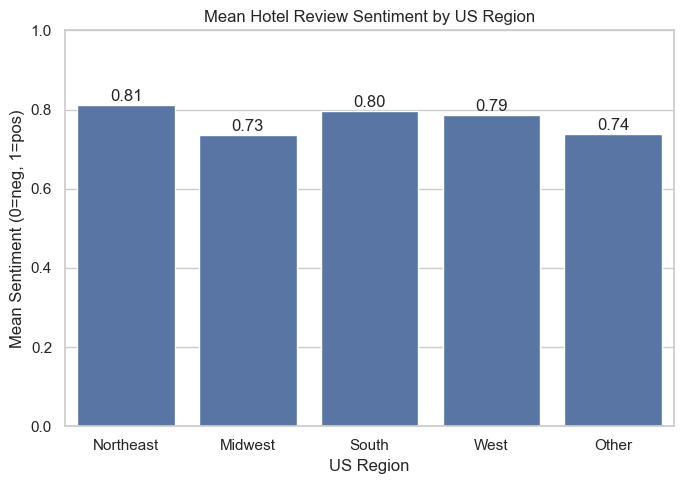

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

loc_df = df2.copy()

loc_df['province'] = loc_df['province'].astype(str).str.upper().str.strip()

region_map = {
    'ME':'Northeast','NH':'Northeast','VT':'Northeast','MA':'Northeast',
    'RI':'Northeast','CT':'Northeast','NY':'Northeast','NJ':'Northeast',
    'PA':'Northeast',
    'OH':'Midwest','IN':'Midwest','IL':'Midwest','MI':'Midwest','WI':'Midwest',
    'MN':'Midwest','IA':'Midwest','MO':'Midwest','ND':'Midwest','SD':'Midwest',
    'NE':'Midwest','KS':'Midwest',
    'DE':'South','MD':'South','DC':'South','VA':'South','WV':'South',
    'NC':'South','SC':'South','GA':'South','FL':'South',
    'KY':'South','TN':'South','MS':'South','AL':'South',
    'OK':'South','TX':'South','AR':'South','LA':'South',
    'MT':'West','ID':'West','WY':'West','CO':'West','NM':'West','AZ':'West',
    'UT':'West','NV':'West','WA':'West','OR':'West','CA':'West','AK':'West','HI':'West'
}

loc_df['region'] = loc_df['province'].map(region_map).fillna('Other')

region_rates = (loc_df
                .groupby('region')['sentiment']
                .mean()
                .reindex(['Northeast','Midwest','South','West','Other'])
                .dropna()
               )

plt.figure(figsize=(7,5))
sns.barplot(x=region_rates.index, y=region_rates.values)
plt.ylim(0,1)
plt.ylabel('Mean Sentiment (0=neg, 1=pos)')
plt.xlabel('US Region')
plt.title('Mean Hotel Review Sentiment by US Region')
for i, v in enumerate(region_rates.values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.tight_layout()
plt.show()




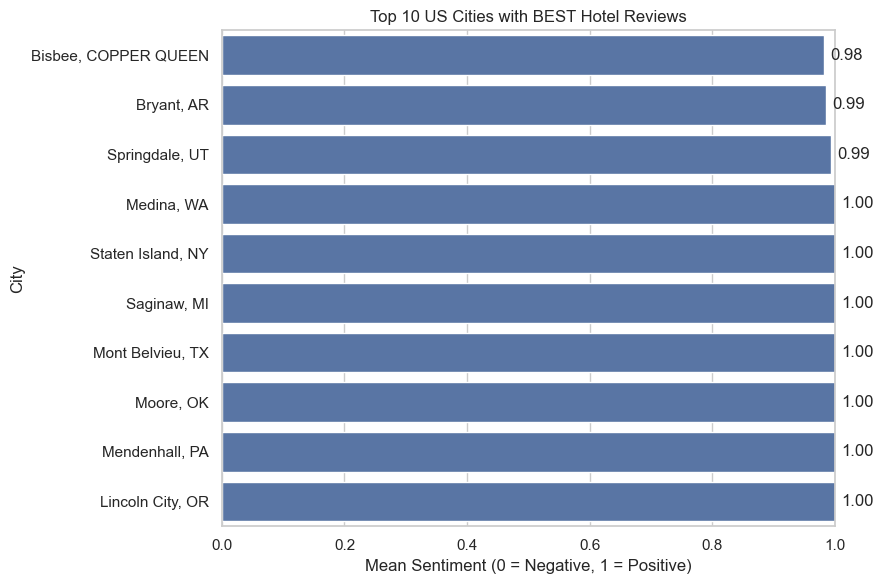

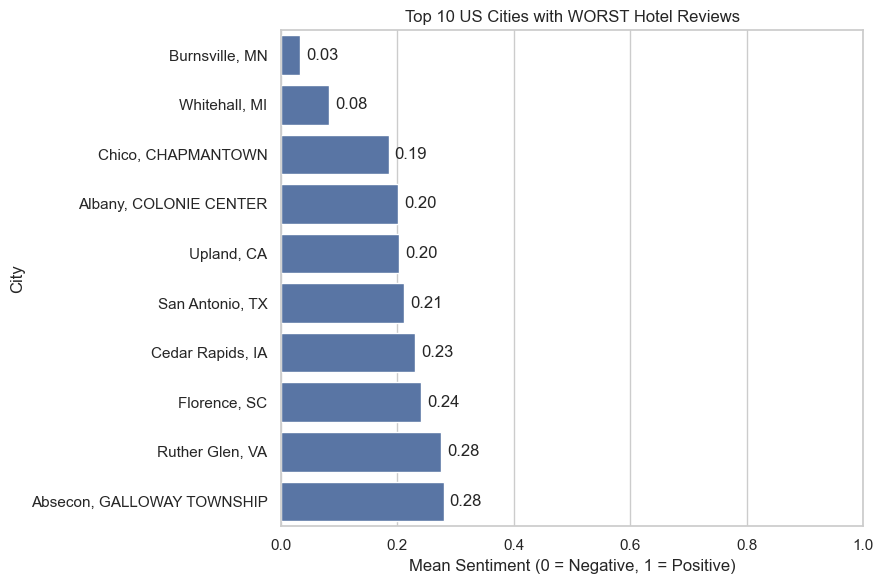

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")


city_df = df[['reviews.rating', 'province', 'city']].copy()

city_df = city_df.dropna(subset=['reviews.rating', 'province', 'city'])
city_df['reviews.rating'] = pd.to_numeric(city_df['reviews.rating'], errors='coerce')
city_df = city_df.dropna(subset=['reviews.rating'])

city_df = city_df[city_df['reviews.rating'] != 3]

city_df['sentiment'] = city_df['reviews.rating'].apply(lambda r: 1 if r >= 4 else 0)

city_df['province'] = city_df['province'].astype(str).str.upper().str.strip()
city_df['city'] = city_df['city'].astype(str).str.strip()


city_stats = (
    city_df
    .groupby(['city', 'province'])['sentiment']
    .agg(['mean', 'count'])
    .rename(columns={'mean':'positive_rate', 'count':'n_reviews'})
    .reset_index()
)

# Only keep cities with enough reviews to be meaningful
MIN_REVIEWS_PER_CITY = 50
eligible_cities = city_stats[city_stats['n_reviews'] >= MIN_REVIEWS_PER_CITY].copy()

eligible_cities['label'] = (
    eligible_cities['city'] + ', ' + eligible_cities['province']
)

# Top 10 best cities

top10 = (eligible_cities
         .sort_values('positive_rate', ascending=False)
         .head(10)
         .sort_values('positive_rate', ascending=True))

plt.figure(figsize=(9,6))
sns.barplot(x='positive_rate', y='label', data=top10)
plt.xlim(0,1)
plt.xlabel('Mean Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('City')
plt.title('Top 10 US Cities with BEST Hotel Reviews')

for i, v in enumerate(top10['positive_rate']):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()


# Top 10 worst cities
bottom10 = (eligible_cities
            .sort_values('positive_rate', ascending=True)
            .head(10)
            .sort_values('positive_rate', ascending=True))

plt.figure(figsize=(9,6))
sns.barplot(x='positive_rate', y='label', data=bottom10)
plt.xlim(0,1)
plt.xlabel('Mean Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('City')
plt.title('Top 10 US Cities with WORST Hotel Reviews')

for i, v in enumerate(bottom10['positive_rate']):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()
